# 1. Initialisation du Dataset

## 1.1. Importer le Dataset

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Sleep_Data_Sampled.csv")

## 1.2. Vérification du Dataset

In [19]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                15000 non-null  int64  
 1   Gender                   15000 non-null  object 
 2   Age                      15000 non-null  int64  
 3   Occupation               15000 non-null  object 
 4   Sleep Duration           15000 non-null  float64
 5   Quality of Sleep         15000 non-null  int64  
 6   Physical Activity Level  15000 non-null  int64  
 7   Stress Level             15000 non-null  int64  
 8   BMI Category             15000 non-null  object 
 9   Blood Pressure           15000 non-null  object 
 10  Heart Rate               15000 non-null  int64  
 11  Daily Steps              15000 non-null  int64  
 12  Sleep Disorder           15000 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usage: 1.5+ MB


,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7500.500000,44.130667,6.997327,7.131267,59.925000,5.654800,70.857533,6795.080000
std,4330.271354,6.840091,0.615187,1.053111,16.814374,1.393568,3.614836,1329.706484
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,3750.750000,40.000000,6.500000,6.000000,45.000000,4.000000,68.000000,6000.000000
50%,7500.500000,44.000000,7.000000,7.000000,60.000000,6.000000,70.000000,6500.000000
75%,11250.250000,48.000000,7.450000,8.000000,75.000000,6.000000,72.000000,7600.000000
max,15000.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


# 2. Premiers graphes
## 2.1. Histogrammes pour voir la distribution des variables numériques

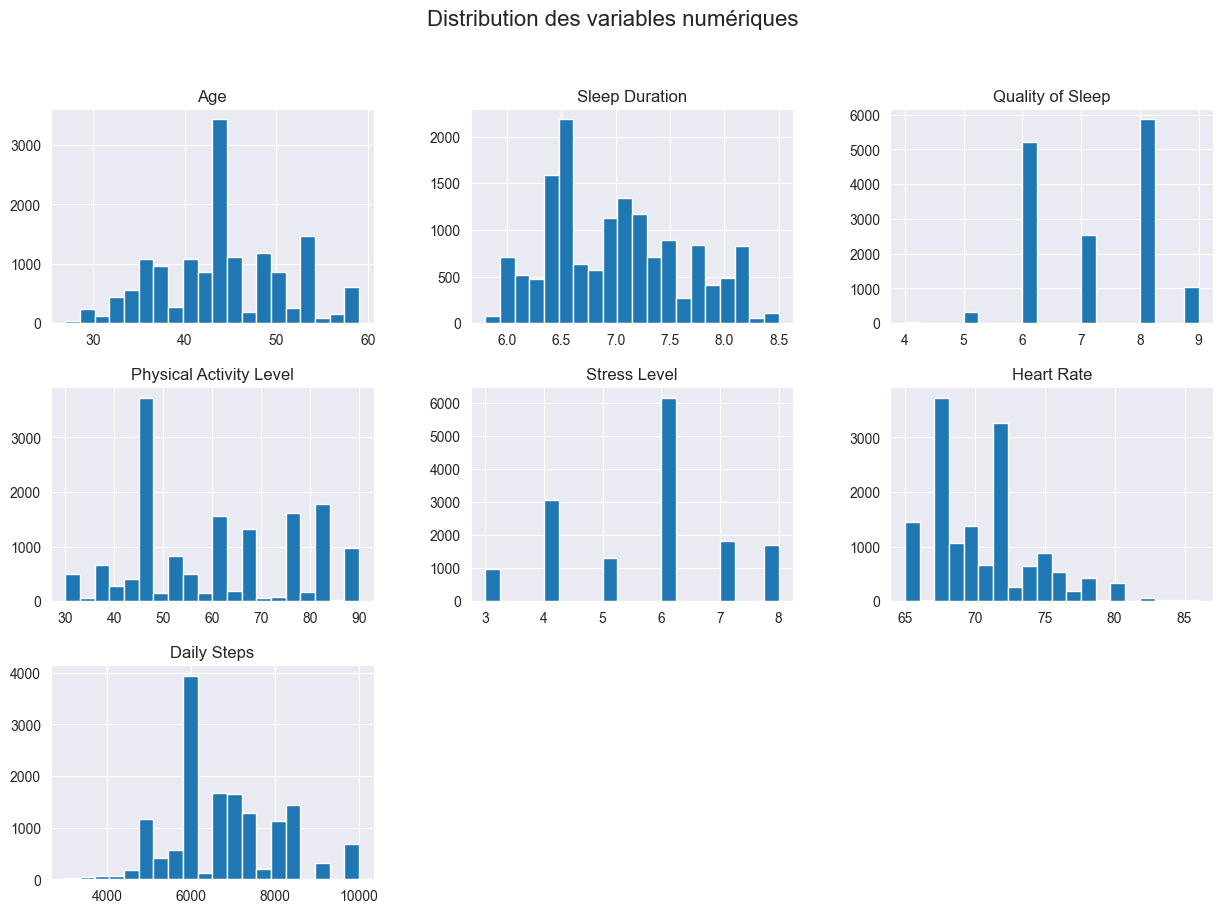

In [20]:
# 1. Histogrammes pour voir la distribution des variables numériques
numerical_cols = ['Age', 'Sleep Duration', 'Quality of Sleep',
                  'Physical Activity Level', 'Stress Level',
                  'Heart Rate', 'Daily Steps']

df[numerical_cols].hist(bins=20, figsize=(15,10))
plt.suptitle("Distribution des variables numériques", fontsize=16)
plt.show()

## 2.2. Boxplots pour comparer les variables numériques selon le sexe


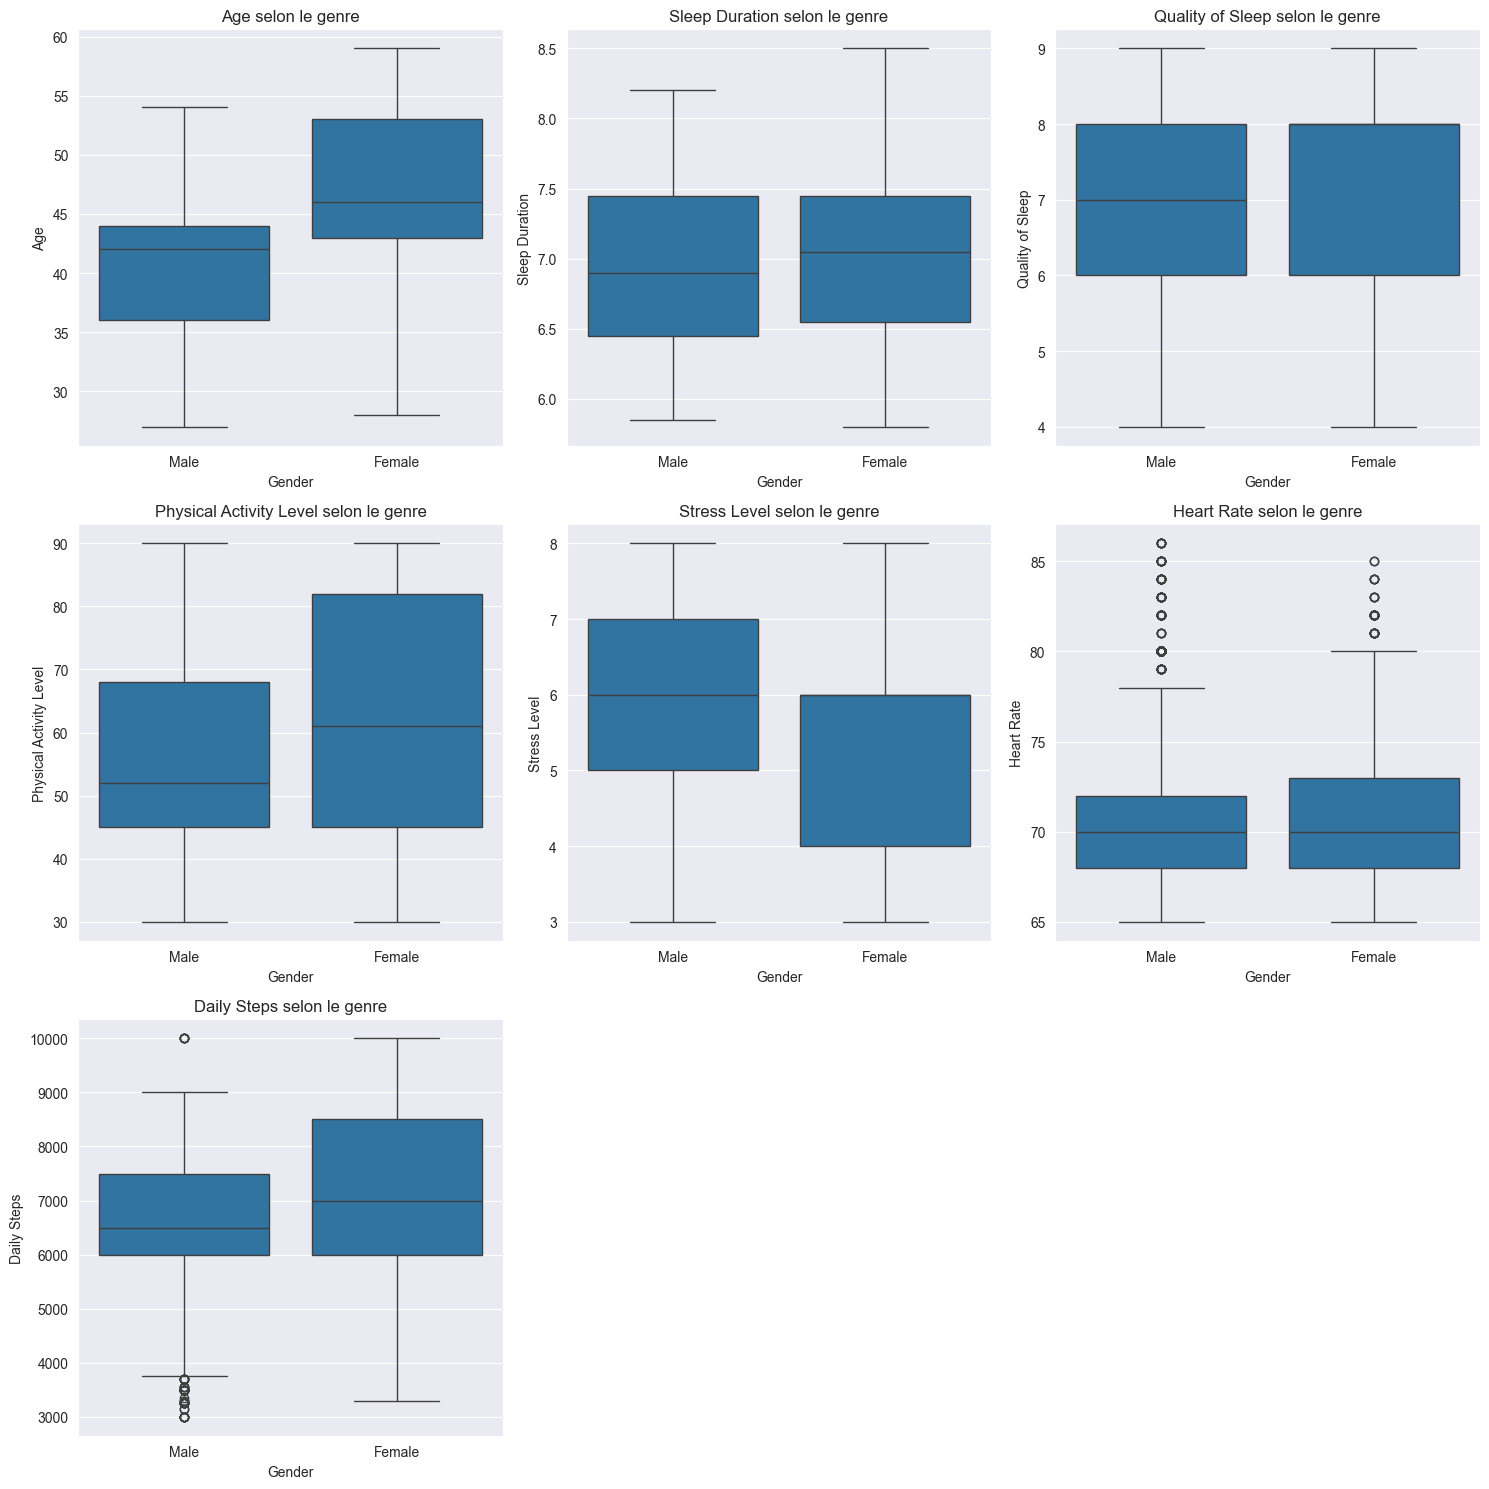

In [21]:
# Nombre de colonnes numériques
num_cols = len(numerical_cols)

# On fait 3 lignes
rows = 3
cols = (num_cols + rows - 1) // rows  # calcule le nombre de colonnes nécessaires

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
axes = axes.flatten()  # pour simplifier l'accès aux axes

for i, col in enumerate(numerical_cols):
    sns.boxplot(x='Gender', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} selon le genre')

# Supprimer les axes vides si num_cols < rows*cols
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 2.3. Heatmap de corrélation entre les variables numériques



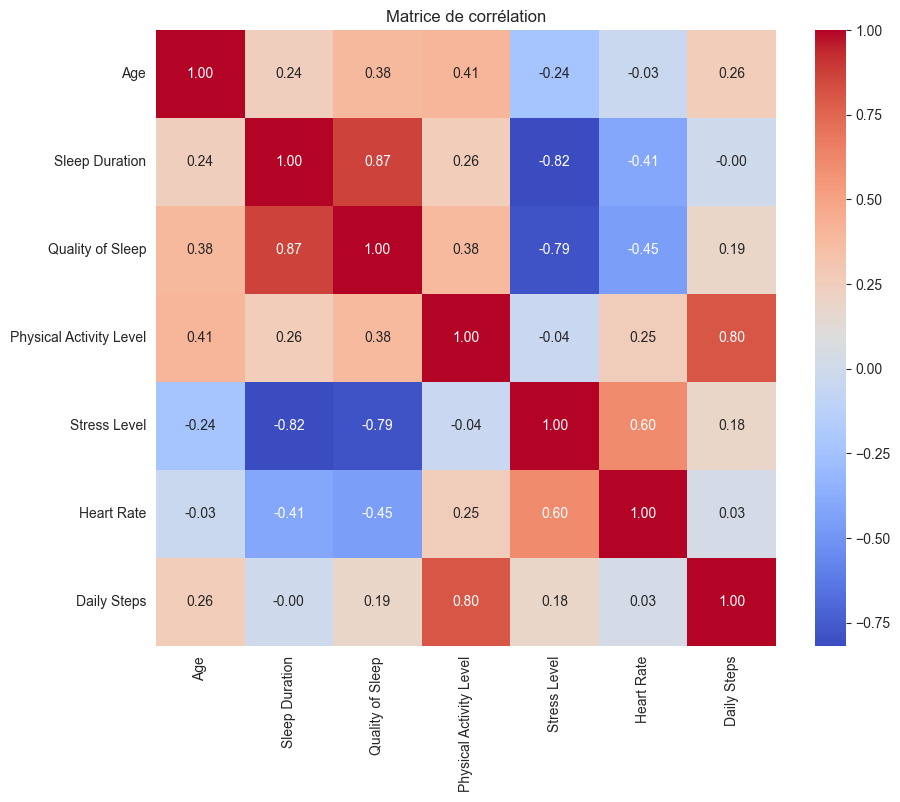

In [22]:
plt.figure(figsize=(10,8))
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

## 2.4. Comptage des Sleep Disorders par catégorie (bar plot)


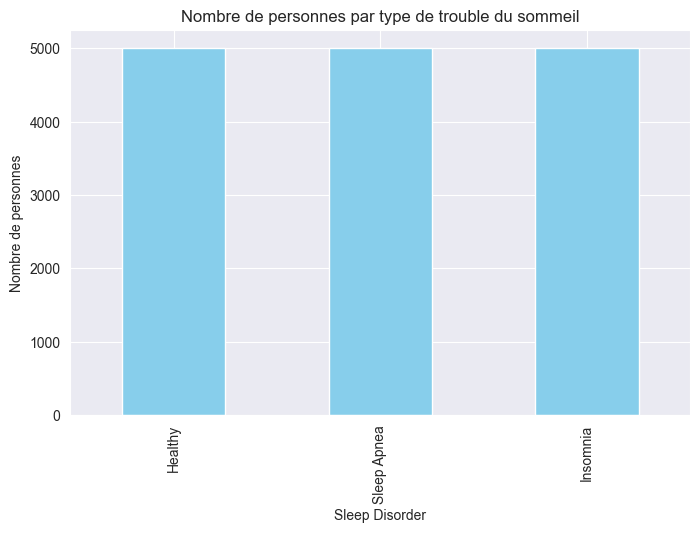

In [23]:
plt.figure(figsize=(8,5))
df['Sleep Disorder'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Nombre de personnes par type de trouble du sommeil")
plt.xlabel("Sleep Disorder")
plt.ylabel("Nombre de personnes")
plt.show()

# 3. Kmeans


## 3.1 Prétraitement des données (Preprocessing)

Nous allons transformer la colonne "Blood Pressure", encoder les variables catégoriques (comme le Genre ou l'Occupation) et mettre toutes les variables à la même échelle.

In [29]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 1. Nettoyage et Feature Engineering
# Séparer la pression sanguine en deux colonnes numériques
df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)

# Sélection des colonnes pour le clustering
# On exclut 'Person ID' (inutile) et 'Blood Pressure' (remplacée)
features_to_use = [col for col in df.columns if col not in ['Person ID', 'Blood Pressure']]
# Note: On garde ou on retire 'Sleep Disorder' selon si on veut que le modèle le "devine" ou l'utilise.

# Séparation des types de colonnes
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
                    'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']
categorical_features = ['Gender', 'Occupation', 'BMI Category']

# Si 'Sleep Disorder' est vide ou NaN, on remplace par "None" pour le traiter comme une catégorie
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')
categorical_features.append('Sleep Disorder')

# Création du Pipeline de transformation
# - Numérique : Standardisation (Moyenne 0, Ecart-type 1)
# - Catégorique : OneHotEncoding (Transformation en 0 et 1)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Application de la transformation
X_scaled = preprocessor.fit_transform(df)

print("Données prêtes pour le clustering. Forme de la matrice :", X_scaled.shape)

Données prêtes pour le clustering. Forme de la matrice : (15000, 29)


##  3.2 Méthode du Coude (Elbow Method)

Pour savoir combien de groupes (K) nous devons créer, nous allons tester de 1 à 10 clusters et regarder à quel moment l'inertie (la somme des erreurs au carré) cesse de diminuer rapidement.

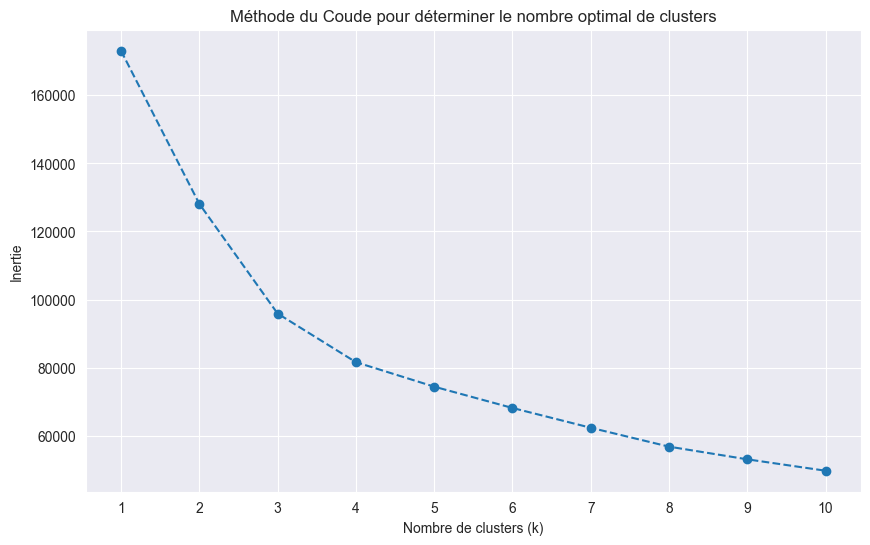

In [30]:
from sklearn.cluster import KMeans

# Liste pour stocker l'inertie (somme des carrés des distances intra-cluster)
inertia = []
range_k = range(1, 11)

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Affichage du graphe
plt.figure(figsize=(10, 6))
plt.plot(range_k, inertia, marker='o', linestyle='--')
plt.title('Méthode du Coude pour déterminer le nombre optimal de clusters')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.xticks(range_k)
plt.grid(True)
plt.show()

## 3.3 Application du K-Means et Visualisation (PCA)

D'après la courbe (qui forme un coude autour de 3 ou 4), fixons arbitrairement k=3.

Nous utiliserons une ACP (Analyse en Composantes Principales) pour réduire les dimensions et visualiser les clusters en 2D.

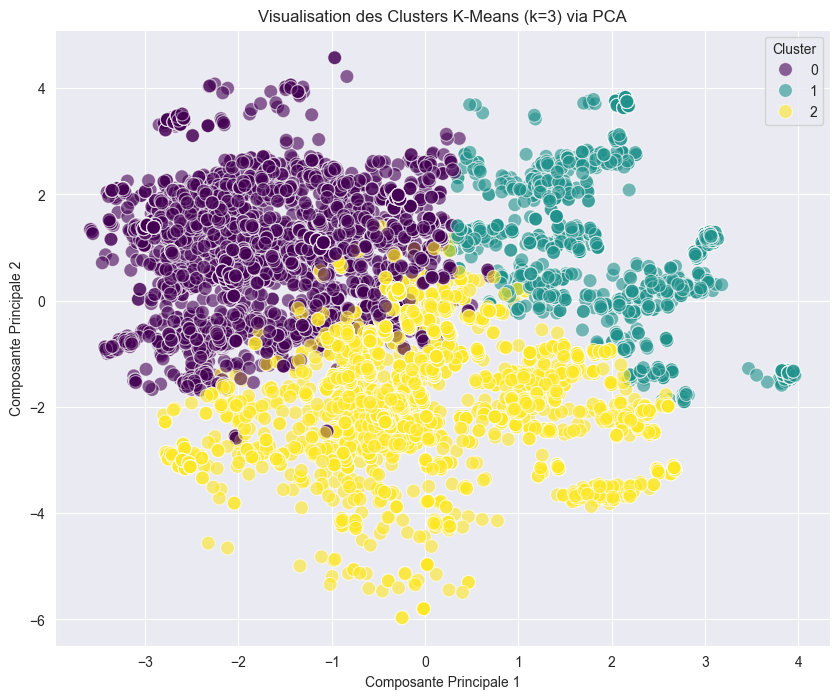

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Entraînement du modèle K-Means (si ce n'est pas déjà fait)
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Ajout des clusters au dataframe original pour l'analyse
df['Cluster'] = clusters

# 2. Visualisation avec PCA
pca = PCA(n_components=2)

# CORRECTION ICI : On vérifie si les données sont sparse ou non avant de convertir
if hasattr(X_scaled, 'toarray'):
    X_input = X_scaled.toarray()
else:
    X_input = X_scaled

X_pca = pca.fit_transform(X_input)

# Affichage du graphique
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='viridis', s=100, alpha=0.6)
plt.title(f'Visualisation des Clusters K-Means (k={k_optimal}) via PCA')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='Cluster')
plt.show()

## 3.4 Interprétation des clusters

Enfin, regardons les statistiques moyennes de chaque groupe pour comprendre ce qu'ils représentent (ex: "Les sportifs peu stressés", "Les insomniaques âgés", etc.).

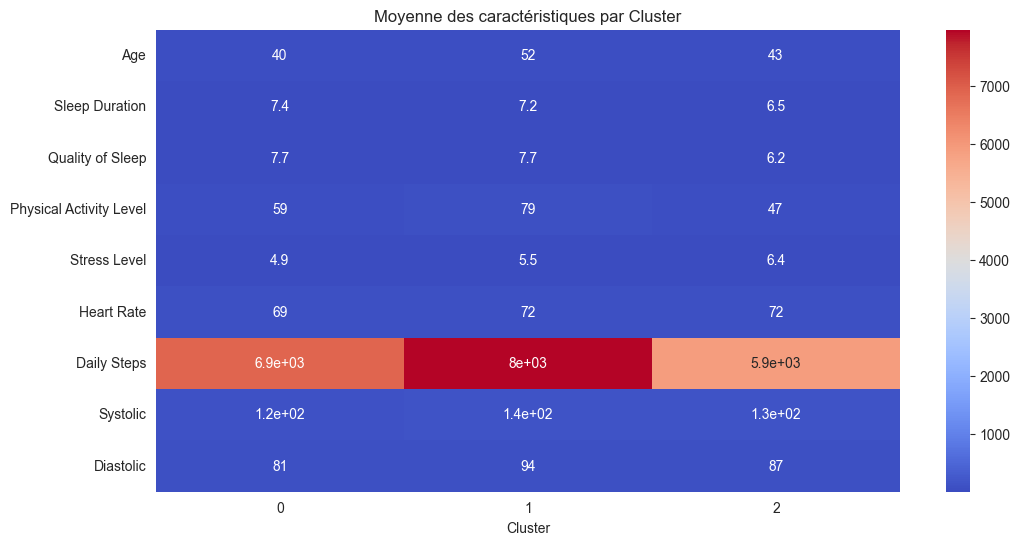

               Age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
Cluster                                                                         
0        39.834122        7.409241          7.739443                59.336868   
1        52.259050        7.164891          7.745828                79.495764   
2        42.590488        6.511753          6.168784                47.369677   

         Stress Level  Heart Rate  Daily Steps    Systolic  Diastolic  
Cluster                                                                
0            4.949820   68.802878  6903.683015  124.035031  80.984662  
1            5.536072   72.330167  7966.264442  139.591271  94.467009  
2            6.373455   71.735749  5913.332761  132.477507  87.244505  


In [38]:
# Analyse des moyennes par cluster pour les variables numériques
cluster_analysis = df.groupby('Cluster')[numeric_features].mean()

# Affichage avec une heatmap pour faciliter la lecture (normalisée par colonne pour comparer)
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_analysis.T, annot=True, cmap='coolwarm')
plt.title('Moyenne des caractéristiques par Cluster')
plt.show()

# Afficher quelques statistiques descriptives textuelles
print(cluster_analysis)